# TSSL Lab 1 - Autoregressive models

We load a few packages that are useful for solvign this lab assignment.

In [1]:
import pandas as pd  # Loading data / handling data frames
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model as lm  # Used for solving linear regression problems
from sklearn.neural_network import MLPRegressor # Used for NAR model

from tssltools_lab1 import acf, acfplot # Module available in LISAM - Used for plotting ACF

## 1.1 Loading, plotting and detrending data

In this lab we will build autoregressive models for a data set corresponding to the Global Mean Sea Level (GMSL) over the past few decades. The data is taken from https://climate.nasa.gov/vital-signs/sea-level/ and is available on LISAM in the file `sealevel.csv`.

**Q1**: Load the data and plot the GMSL versus time. How many observations are there in total in this data set?

_Hint:_ With pandas you can use the function `pandas.read_csv` to read the csv file into a data frame. Plotting the time series can be done using `pyplot`. Note that the sea level data is stored in the 'GMSL' column and the time when each data point was recorded is stored in the column 'Year'.

**A1**: There are 1119 observations in total in the GMSL dataset.

<AxesSubplot: title={'center': 'Year vs. GMSL'}, xlabel='Year'>

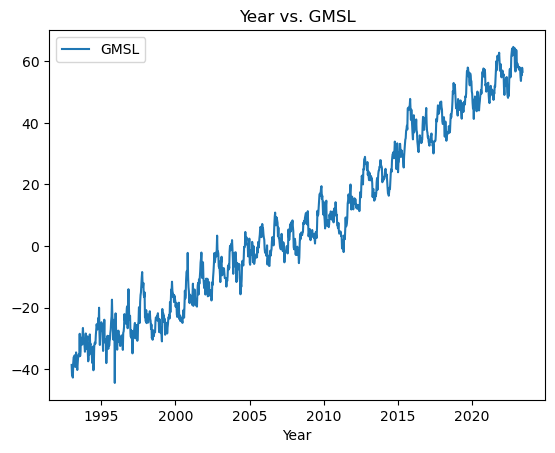

In [2]:
df = pd.read_csv('sealevel.csv')
df.plot(x='Year', y='GMSL', title = 'Year vs. GMSL')

**Q2**: The data has a clear upward trend. Before fitting an AR model to this data need to remove this trend. Explain, using one or two sentences, why this is necessary.

**A2:** We detrend the data because AR models assume that the data is stationary in nature i.e., constant mean and finite variance.

**Q3** Detrend the data following these steps:
1. Fit a straight line, $\mu_t=\theta_0 + \theta_1 u_t $ to the data based on the method of least squares. Here, $u_t$ is the time point when obervation $t$ was recorded.

    _Hint:_ You can use `lm.LinearRegression().fit(...)` from scikit-learn. Note that the inputs need to be passed as a 2D array.

    Before going on to the next step, plot your fitted line and the data in one figure.


2. Subtract the fitted line from $y_t$ for the whole data series and plot the deviations from the straight line.

**From now, we will use the detrended data in all parts of the lab.**

_Note:_ The GMSL data is recorded at regular time intervals, so that $u_{t+1} - u_t = $ const. Therefore, you can just as well use $t$ directly in the linear regression function if you prefer, $\mu_t=\theta_0 + \theta_1 t $.

**A3:**

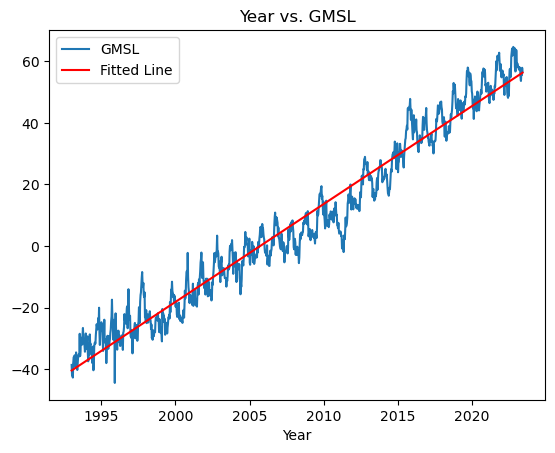

In [3]:
#Q3 Subquestion1

#Getting Covariates and Response
x = np.array(df['Year'])
x_reshaped = np.array(df['Year']).reshape(-1, 1)
y = np.array(df['GMSL'])


#Fitting Linear Reg
lm_fit = lm.LinearRegression().fit(x_reshaped, y)

#Extracting model parameters
theta_0 = lm_fit.intercept_
theta_1 = lm_fit.coef_[0]

pred = theta_0 + theta_1 * x

df.plot(x='Year', y='GMSL', title = 'Year vs. GMSL')
plt.plot(x, pred, color='red', label='Fitted Line')
plt.legend()

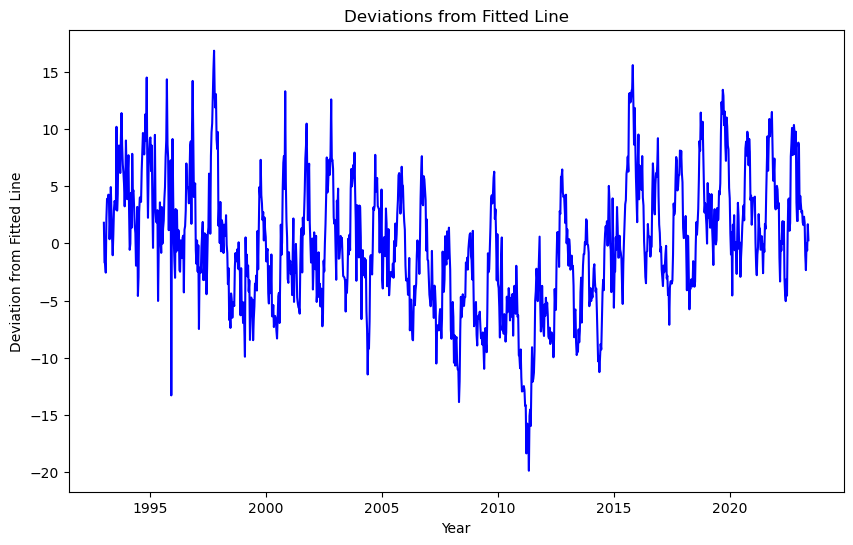

In [4]:
#Q3 Subquestion2

deviation = y - pred
#deviation is the detrended data

plt.figure(figsize=(10, 6))
plt.plot(x, deviation, color='blue')
plt.xlabel('Year')
plt.ylabel('Deviation from Fitted Line')
plt.title('Deviations from Fitted Line')
plt.show()

**Q4:** Split the (detrended) time series into training and validation sets. Use the values from the beginning up to the 700th time point (i.e. $y_t$ for $t=1$ to $t=700$) as your training data, and the rest of the values as your validation data. Plot the two data sets.

_Note:_ In the above, we have allowed ourselves to use all the available data (train + validation) when detrending. An alternative would be to use only the training data also when detrending the model. The latter approach is more suitable if, either:
* we view the linear detrending as part of the model choice. Perhaps we wish to compare different polynomial trend models, and evaluate their performance on the validation data, or
* we wish to use the second chunk of observations to estimate the performance of the final model on unseen data (in that case it is often referred to as "test data" instead of "validation data"), in which case we should not use these observations when fitting the model, including the detrending step.

In this laboration we consider the linear detrending as a predetermined preprocessing step and therefore allow ourselves to use the validation data when computing the linear trend.

**A4:**

Length of Training: 700, Length of Validation: 419


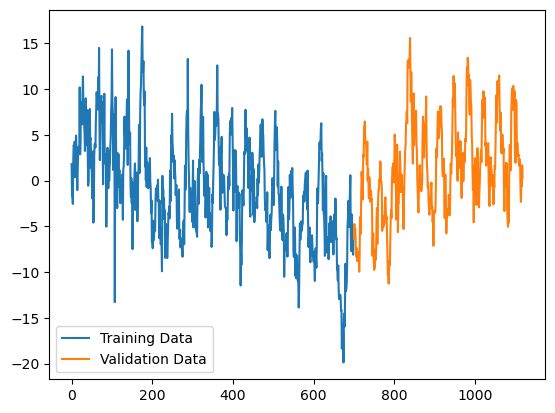

In [5]:
data_train = deviation[:700,]
data_validation = deviation[700:,]
print(f'Length of Training: {len(data_train)}, Length of Validation: {len(data_validation)}')
plt.plot(range(700), data_train, label = 'Training Data')
plt.plot(range(700,1119), data_validation, label = 'Validation Data')
plt.legend()

## 1.2 Fit an autoregressive model
We will now fit an AR$(p)$ model to the training data for a given value of the model order $p$.

**Q5**: Create a function that fits an AR$(p)$ model for an arbitrary value of p. Use this function to fit a model of order $p=10$ to the training data and write out (or plot) the coefficients.

_Hint:_ Since fitting an AR model is essentially just a standard linear regression we can make use of `lm.LinearRegression().fit(...)` similarly to above. You may use the template below and simply fill in the missing code.

**A5:**

In [6]:
def fit_ar(y, p):
    """Fits an AR(p) model. The loss function is the sum of squared errors from t=p+1 to t=n.

    :param y: array (n,), training data points
    :param p: int, AR model order
    :return theta: array (p,), learnt AR coefficients
    """

    # Number of training data points
    n = len(y) # <COMPLETE THIS LINE>
    
    # Construct the regression matrix
    Phi = np.zeros((n-p, p)) # <COMPLETE THIS LINE>
    for j in range(p):
        Phi[:,j] = y[p - j - 1 : n - j - 1] # <COMPLETE THIS LINE>
    
    # Drop the first p values from the target vector y
    yy = y[p:]  # yy = (y_{t+p+1}, ..., y_n)

    # Here we use fit_intercept=False since we do not want to include an intercept term in the AR model
    regr = lm.LinearRegression(fit_intercept=False)
    regr.fit(Phi,yy)    

    return regr.coef_

In [7]:
thetas_ar = fit_ar(data_train, p=10)
print('The coefficients of the AR(10) model are as follows:',thetas_ar)

The coefficients of the AR(10) model are as follows: [ 0.63068183  0.1231388   0.12558768  0.17683292 -0.02284342 -0.07140349
 -0.05693816  0.0479181  -0.0893176   0.0251526 ]


**Q6:** Next, write a function that computes the one-step-ahead prediction of your fitted model. 'One-step-ahead' here means that in order to predict $y_t$ at $t=t_0$, we use the actual values of $y_t$ for $t<t_0$ from the data. Use your function to compute the predictions for both *training data* and *validation data*. Plot the predictions together with the data (you can plot both training and validation data in the same figure). Also plot the *residuals*.

_Hint:_ It is enought to call the predict function once, for both training and validation data at the same time.

**A6:**

In [8]:
def predict_ar_1step(theta, y_target):
    """Predicts the value y_t for t = p+1, ..., n, for an AR(p) model, based on the data in y_target using
    one-step-ahead prediction.

    :param theta: array (p,), AR coefficients, theta=(a1,a2,...,ap).
    :param y_target: array (n,), the data points used to compute the predictions.
    :return y_pred: array (n-p,), the one-step predictions (\hat y_{p+1}, ...., \hat y_n) 
    """

    n = len(y_target)
    p = len(theta)
    
    # Number of steps in prediction
    m = n-p
    y_pred = np.zeros(m)
    
    for i in range(m):
        # <COMPLETE THIS CODE BLOCK>
        y_pred[i] = np.dot(theta, y_target[i : i + p][::-1]) # <COMPLETE THIS LINE>
        
    return y_pred

In [9]:
# ar_pred_train = predict_ar_1step(thetas_ar, data_train)
# ar_pred_valid = predict_ar_1step(thetas_ar, data_validation)
ar_pred = predict_ar_1step(thetas_ar, deviation)

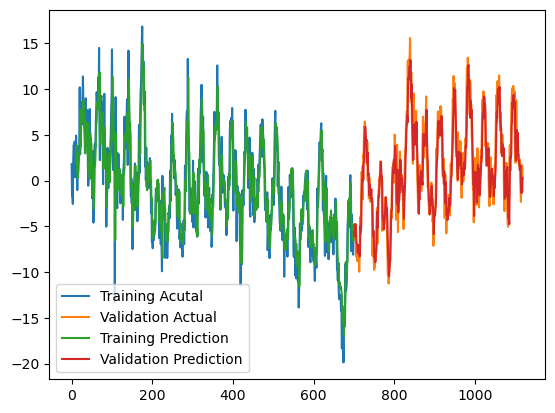

In [10]:
plt.plot(range(700), deviation[:700], label = 'Training Acutal')
plt.plot(range(700, 1119), deviation[700:], label = 'Validation Actual')
plt.legend()
plt.plot(range(10, 700), ar_pred[:690], label = 'Training Prediction')
plt.plot(range(700, 1119), ar_pred[690:], label = 'Validation Prediction')
plt.legend()

Length of Training Resids: 690, Length of Validation Resids: 419


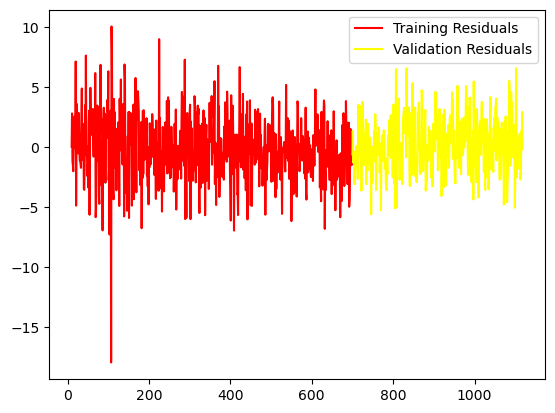

In [11]:
train_resid = data_train[10:] - ar_pred[:690]
valid_resid = data_validation - ar_pred[690:]
print(f'Length of Training Resids: {len(train_resid)}, Length of Validation Resids: {len(valid_resid)}')
plt.plot(range(10, 700), train_resid, color = 'red', label = 'Training Residuals')
plt.plot(range(700, 1119), valid_resid, color = 'yellow', label = 'Validation Residuals')
plt.legend()

**Q7:** Compute and plot the autocorrelation function (ACF) of the *residuals* only for the *validation data*. What conclusions can you draw from the ACF plot?

_Hint:_ You can use the function `acfplot` from the `tssltools` module, available on the course web page.

**A7:** From the ACF plot below, we can observe that there is statistically significant correlation to lag points greater than 10 (more than 200), although the order of the AR model is set to 10. This signifies that AR(10) is inappropriate to capture temporal dependencies in the data and hence we may have to increase the order of the model.

In [12]:
help(acfplot)

Help on function acfplot in module tssltools_lab1:

acfplot(x, lags=None, conf=0.95)
    Plots the empirical autocorralation function.
    
    :param x: array (n,), sequence of data points
    :param lags: int, maximum lag to compute the ACF for. If None, this is set to n-1. Default is None.
    :param conf: float, number in the interval [0,1] which specifies the confidence level (based on a central limit
                 theorem under a white noise assumption) for two dashed lines drawn in the plot. Default is 0.95.
    :return:



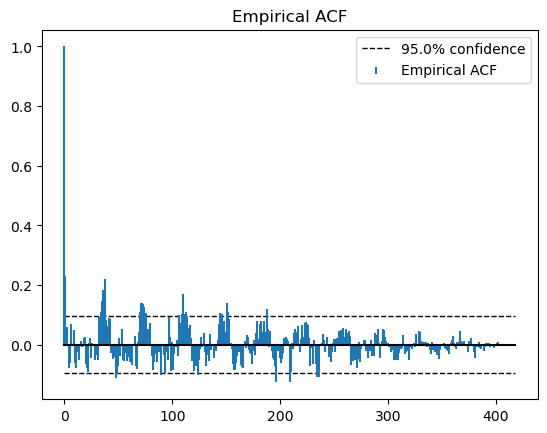

In [13]:
acfplot(valid_resid)

## 1.3 Model validation and order selection
Above we set the model order $p=10$ quite arbitrarily. In this section we will try to find an appropriate order by validation.

**Q8**: Write a loop in which AR-models of orders from $p=2$ to $p=150$ are fitted to the data above. Plot the training and validation mean-squared errors for the one-step-ahead predictions versus the model order.

Based on your results:
- What is the main difference between the changes in training error and validation error as the order increases? 
- Based on these results, which model order would you suggest to use and why?

_Note:_ There is no obvious "correct answer" to the second question, but you still need to pick an order an motivate your choice!


**A8:** 
Based on the plot:
- The training mean-squared error continuously decreases as the order increases and this is expected because as the order increases it is able to capture the temporal dependencies very well since it is trained on the training data. On the other hand validation data is the unseen data, and therefore, as the order increases, at first the validation mean-squared error decreases, flattens out and then slowly starts increasing.
- At p_opt=52, we have the lowest validation mean squared error because the model is complex enough to capture the trend but does not over fit the data.

In [14]:
mean_errs_tr = np.zeros(149)
mean_errs_valid = np.zeros(149)
for p in range(2, 151):
    theta = fit_ar(data_train, p)
    # predictions_train = predict_ar_1step(theta, data_train)
    # predictions_valid = predict_ar_1step(theta, data_validation)
    predictions = predict_ar_1step(theta, deviation)
    predictions_train = predictions[:len(data_train)-p]
    predictions_valid = predictions[len(data_train)-p:]
    mean_errs_tr[p - 2] = np.mean((data_train[p:] - predictions_train) ** 2)
    mean_errs_valid[p - 2] = np.mean((data_validation - predictions_valid) ** 2)

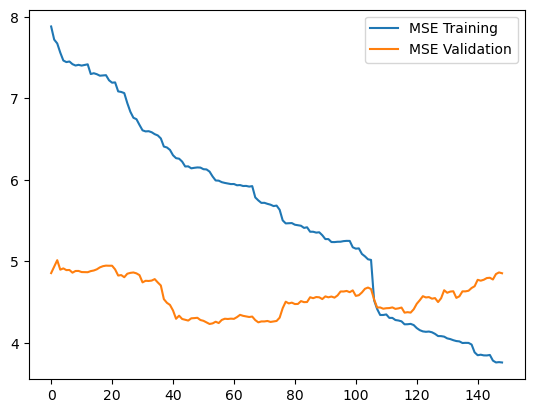

In [15]:
plt.plot(mean_errs_tr, label = 'MSE Training')
plt.plot(mean_errs_valid, label = 'MSE Validation')
plt.legend()

**Q9:** Based on the chosen model order, compute the residuals of the one-step-ahead predictions on the *validation data*. Plot the autocorrelation function of the residuals. What conclusions can you draw? Compare to the ACF plot generated above for p=10.

**A9:** Compared to the ACF plot when p = 10 we observed correlation upto lagged points of 200. In this case, when p = 52, there is significant correlation only upto 120-150th lagged point, but we cannot set p = 150 since after p = 80, the validation error increases implying that the model is overfitting.

In [20]:
p_opt = np.argmin(mean_errs_valid)
print('The optimal model order, p, is:',p_opt)

The optimal model order, p, is: 52


In [21]:
theta_new = fit_ar(data_train, p=p_opt)

new_pred = predict_ar_1step(theta_new, deviation)

new_valid_resid = data_validation - new_pred[700-p_opt:]

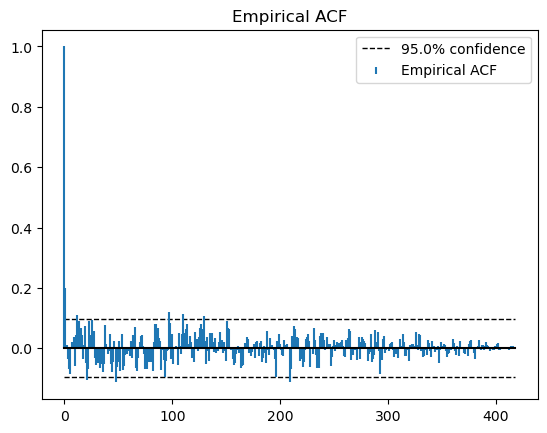

In [22]:
acfplot(new_valid_resid)

## 1.4 Long-range predictions
So far we have only considered one-step-ahead predictions. However, in many practical applications it is of interest to use the model to predict further into the future. For intance, for the sea level data studied in this laboration, it is more interesting to predict the level one year from now, and not just 10 days ahead (10 days = 1 time step in this data).

**Q10**: 
Write a function that simulates the value of an AR($p$) model $m$ steps into the future, conditionally on an initial sequence of data points. Specifically, given $y_{1:n}$ with $n\geq p$ the function/code should predict the values

\begin{align}
    \hat y_{t|n} &= \mathbb{E}[y_{t} | y_{1:n}], & t&=n+1,\dots,n+m.
\end{align}

Use this to predict the values for the validation data ($y_{701:997}$) conditionally on the training data ($y_{1:700}$) and plot the result.

_Hint:_ Use the pseudo-code derived at the first pen-and-paper session.

**A10:**

In [23]:
def simulate_ar(y, theta, m):
    """Simulates an AR(p) model for m steps, with initial condition given by the last p values of y
    
    :param y: array (n,) with n>=p. The last p values are used to initialize the simulation.
    :param theta: array (p,). AR model parameters,
    :param m: int, number of time steps to simulate the model for.
    """

    p = len(theta)    
    y_sim = np.zeros(m)
    phi = np.flip(y[-p:].copy()) # (y_{n-1}, ..., y_{n-p})^T - note that y[ntrain-1] is the last training data point
    for i in range(m):
        y_sim[i] = np.dot(theta, phi) # <COMPLETE THIS LINE>
        # <COMPLETE THIS CODE BLOCK>
        phi = np.insert(phi, 0, y_sim[i])
        phi = np.delete(phi, -1)
    return y_sim
    

In [24]:
sim_pred = simulate_ar(data_train, theta_new, 296)

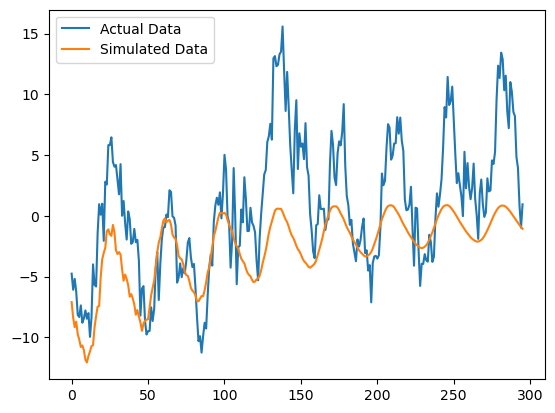

In [25]:
plt.plot(deviation[701:997], label = 'Actual Data')
plt.plot(sim_pred, label = 'Simulated Data')
plt.legend()

**Q11:** Using the same function as above, try to simulate the process for a large number of time steps (say, $m=2000$). You should see that the predicted values eventually converge to a constant prediction of zero. Is this something that you would expect to see in general? Explain the result.

**A11:** We can see below the co-efficients of the AR(52) model are all less than |1| and because this, as time,t tends to infinity(in this case, very large number of time steps i.e., 2000), the predictions converge to 0. 

The coefficients for AR(52) model are: [ 0.52529007  0.08434561  0.11687703  0.16392159  0.02699482  0.01189601
 -0.05237438  0.07407555 -0.06162944  0.05983809 -0.06339494 -0.00980781
  0.00438499 -0.08150589  0.1039569  -0.0412551   0.07023336 -0.02917089
 -0.03087324  0.01023823  0.02036835 -0.01221306 -0.07663109  0.06924342
 -0.03403877 -0.04337307  0.00887955  0.01482158  0.02922846 -0.01950942
  0.02884429  0.06073716  0.04270674  0.01368341  0.05970463  0.08733795
  0.01275779 -0.00486283 -0.08106539 -0.02108338  0.01866309 -0.029447
 -0.07838218  0.06903509 -0.08077115  0.02095535 -0.07959671  0.05581032
 -0.01606734 -0.0184391   0.0247673   0.03936652]


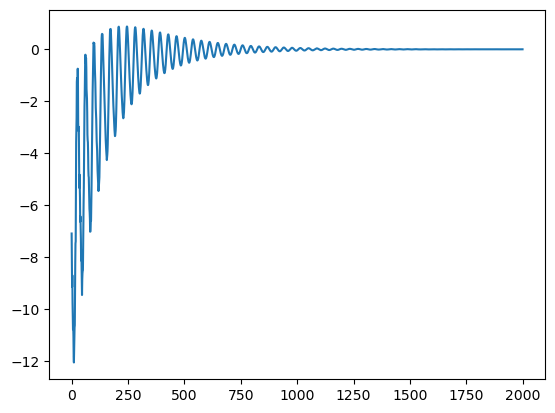

In [26]:
sim_2000 = simulate_ar(data_train, theta_new, 2000)
print('The coefficients for AR(52) model are:',theta_new)
plt.plot(sim_2000)

## 1.5 Nonlinear AR model
 In this part, we switch to a nonlinear autoregressive (NAR) model, which is based on a feedforward neural network. This means that in this model the recursive equation for making predictions is still in the form $\hat y_t=f_\theta(y_{t-1},...,y_{t-p})$, but this time $f$ is a nonlinear function learned by the neural network. Fortunately almost all of the work for implementing the neural network and training it is handled by the `scikit-learn` package with a few lines of code, and we just need to choose the right structure, and prepare the input-output data.   

**Q12**: Construct a NAR($p$) model with a feedforward (MLP) network, by using the `MLPRegressor` class from `scikit-learn`. Set $p$ to the same value as you chose for the linear AR model above. Initially, you can use an MLP with a single hidden layer consisting of 10 hidden neurons. 
Train it using the same training data as above and plot the one-step-ahead predictions as well as the residuals, on both the training and validation data. 

_Hint:_ You will need the methods `fit` and `predict` of `MLPRegressor`. Read the user guide of `scikit-learn` for more details. Recall that a NAR model is conceptuall very similar to an AR model, so you can reuse part of the code from above.

**A12:**

In [28]:
p=p_opt
n1 = len(data_train)

X = np.zeros((n1-p, p))
for j in range(p):
    X[:,j] = data_train[p - j - 1 : n1 - j - 1]
y_train = data_train[p:]


n2 = len(deviation)
X_dev = np.zeros((n2-p, p))
for j in range(p):
    X_dev[:,j] = deviation[p - j - 1 : n2 - j - 1]

nar_model = MLPRegressor(hidden_layer_sizes=(10,),activation='relu').fit(X, y_train)
predictions = nar_model.predict(X_dev)


train_res = data_train[p:] - predictions[:len(data_train)-p]
valid_res = data_validation - predictions[len(data_train)-p:]

C:\Users\Varun\anaconda3\envs\tssl\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


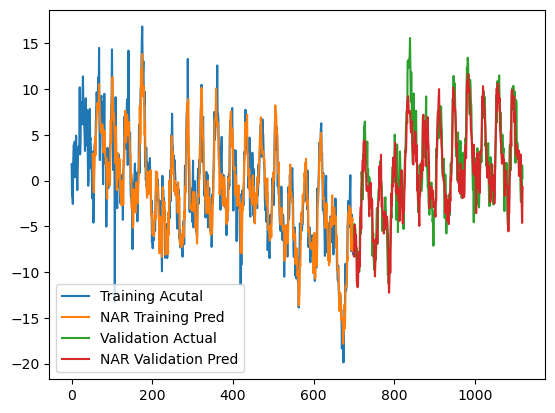

In [30]:
plt.plot(range(700), deviation[:700], label = 'Training Acutal')
plt.plot(range(p_opt, 700),predictions[:700-p_opt], label = 'NAR Training Pred')
plt.plot(range(700, 1119), deviation[700:], label = 'Validation Actual')
plt.plot(range(700,1119),predictions[700-p_opt:], label = 'NAR Validation Pred')
plt.legend()

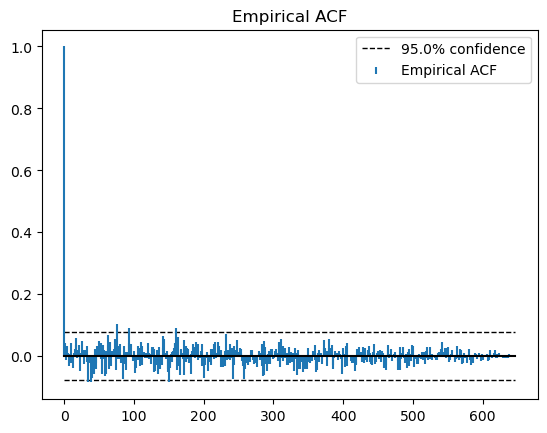

In [33]:
acfplot(train_res)

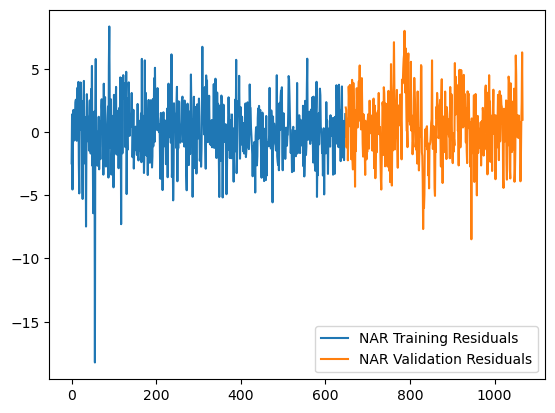

In [38]:
plt.plot(range(700-p_opt),train_res, label = 'NAR Training Residuals')
plt.plot(range(700-p_opt,len(predictions)),valid_res, label = 'NAR Validation Residuals')
plt.legend()

**Q13:** Try to expirement with different choices for the hyperparameters of the network (e.g. number of hidden layers and units per layer, activation function, etc.) and the optimizer (e.g. `solver` and `max_iter`).

Are you satisfied with the results? Why/why not? Discuss what the limitations of this approach might be.

**A13:** The results are not satisfactory when we experiment with different hyperparameter choices since, by tweaking them, we create a much more complex model. Given that we have less data points, such a complex model is bound to overfit on the training data and will have very poor generalization ability as demonstrated in the residuals plot below. That is, the training residuals are almost zero where as, there is an increase in the variance of validation residuals when compared to the above model.

In [60]:
nar_model_exp = MLPRegressor(hidden_layer_sizes=(50, 50, 50, 50), activation='tanh', max_iter=500, solver='sgd').fit(X, y_train)
predictions_exp = nar_model_exp.predict(X_dev)


train_res_exp = data_train[p:] - predictions_exp[:len(data_train)-p]
valid_res_exp = data_validation - predictions_exp[len(data_train)-p:]

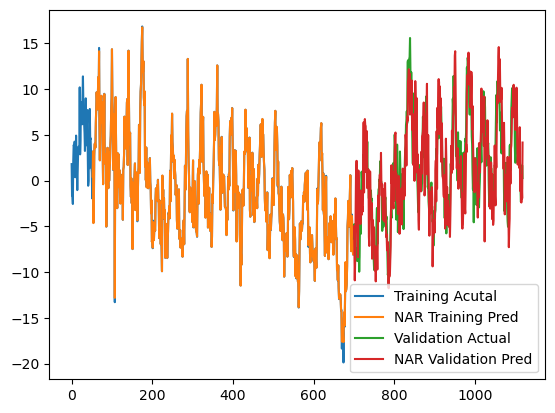

In [61]:
plt.plot(range(700), deviation[:700], label = 'Training Acutal')
plt.plot(range(p_opt, 700),predictions_exp[:700-p_opt], label = 'NAR Training Pred')
plt.plot(range(700, 1119), deviation[700:], label = 'Validation Actual')
plt.plot(range(700,1119),predictions_exp[700-p_opt:], label = 'NAR Validation Pred')
plt.legend()

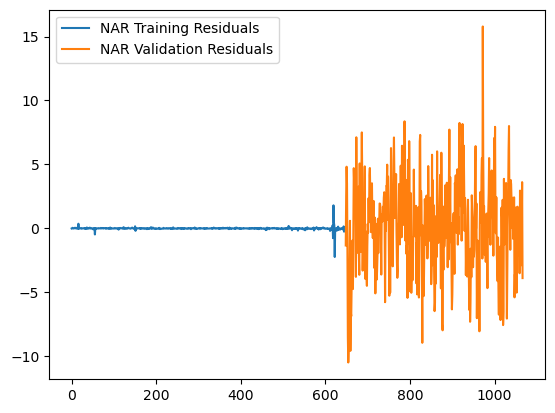

In [63]:
plt.plot(range(700-p_opt),train_res_exp, label = 'NAR Training Residuals')
plt.plot(range(700-p_opt,len(predictions_exp)),valid_res_exp, label = 'NAR Validation Residuals')
plt.legend()